In [ ]:
import json
from os import listdir, makedirs
from os.path import basename, dirname, exists, isfile, join, realpath
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import sys
from matplotlib.legend_handler import HandlerLine2D

==============    bandwidth -> full-speed   ============
{'std': 37.197506188565114, '75th': 15704.9, '25th': 15659.6, '50th': 15684.0, 'max': 15767.3, '99th': 15744.781, 'CoV': 0.0023722923221740477, 'min': 15300.6, '1st': 15556.219000000001, 'npoints': 22320, 'avg': 15679.984224910393}
==============    bandwidth -> 10-30   ============
{'std': 58.64970388791944, '75th': 15457.8, '25th': 15387.3, '50th': 15424.1, 'max': 15569.1, '99th': 15529.856, 'CoV': 0.00380375418547389, 'min': 14841.6, '1st': 15237.228, 'npoints': 7745, 'avg': 15418.89959974177}
==============    bandwidth -> 5-30   ============
{'std': 559.3359166501327, '75th': 15251.0, '25th': 15117.2, '50th': 15182.6, 'max': 15487.8, '99th': 15394.511999999999, 'CoV': 0.03713337319834872, 'min': 7053.8, '1st': 12529.044, 'npoints': 7565, 'avg': 15062.890022471911}


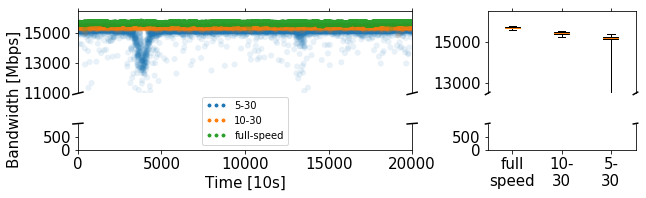

In [5]:


plt.rcParams.update({'font.size': 15})

bw_values = dict()
retransmits = dict()

filedir = realpath("./")
inputdir = realpath(join(filedir, '../data/fig5/'))

def get_statistics(values, message):
	print("==============    " + message + "   ============")
	result = dict()
	result["avg"] = np.mean(values)
	result["std"] = np.std(values)
	result["npoints"] = len(values)
	result["99th"] = np.percentile(values, 99)
	result["75th"] = np.percentile(values, 75)
	result["50th"] = np.percentile(values, 50)
	result["25th"] = np.percentile(values, 25)
	result["1st"] = np.percentile(values, 1)
	result["CoV"] = result["std"] / result["avg"]
	result["min"] = np.min(values)
	result["max"] = np.max(values)
	print(result)
	print("================================")
	return result

def get_bw_per_machine(machine_file, bw_values, retr):
	crnt_file = open(machine_file)
	data = json.load(crnt_file)

	no_intervals = len(data["intervals"])
	bandwidth = 0

	for i in range(0, no_intervals):
		no_bytes = data["intervals"][i]["sum"]["bits_per_second"]
		bandwidth = no_bytes / (1000 * 1000)
		bw_values.append(bandwidth)
		retr.append(data["intervals"][i]["sum"]["retransmits"])

fig = figure(num=None, figsize = (9, 3))
gs=GridSpec(3,3, width_ratios = [3, 0.5, 2]) # 3 rows, 3 columns
ax1 = fig.add_subplot(gs[:2, :2])
ax2 = plt.subplot(gs[:2, 2])
ax3 = plt.subplot(gs[2, :2], sharex=ax1)
ax4 = plt.subplot(gs[2, 2], sharex=ax2)
hindex = 0
dirnames = ["full-speed", "10-30", "5-30"]
stats = dict()

for d in dirnames:
	bw_values[d] = []
	retransmits[d] = []

	dirname = join(inputdir, d)
	machine_files = sorted([join(dirname, f) for f in listdir(dirname) if isfile(join(dirname, f)) and f.endswith(".json")])
	partnames = ["cmeans", "cmedians", "cmaxes", "cmins", "cbars"]

	for machine_file in machine_files:
		get_bw_per_machine(machine_file, bw_values[d], retransmits[d])

	stats[d] = get_statistics(bw_values[d], "bandwidth -> " + d)
	hindex += 1

top_ticks = np.arange(11000, 16500, 2000)
bottom_ticks = np.arange(0, 1000, 500)

ax1.set_xlim(0, 20000)
ax3.set_xlim(0, 20000)
ax3.set_ylim(0, 1000)
ax1.set_ylim(11000,16500)
ax1.set_yticks(top_ticks)
ax3.set_yticks(bottom_ticks)
ax1.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax3.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax3.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
fig.text(0, 0.5, 'Bandwidth [Mbps]', va='center', rotation='vertical')

arr = []
x = 0

for i in range(0, len(bw_values["5-30"])):
	arr.append(x)
	x += 3.5

ax1.scatter(arr, bw_values["5-30"], c='#1f77b4', edgecolors='none', alpha=0.1, label = "5-30", rasterized=True)
arr = []
x = 0

for j in range(0, len(bw_values["10-30"])):
	arr.append(x)
	x += 4

ax1.scatter(arr, bw_values["10-30"], c='#ff7f0e', edgecolors='none', alpha=0.1, label = "10-30", rasterized=True)
ax1.scatter(np.arange(0, len(bw_values["full-speed"])), bw_values["full-speed"], edgecolors='none', c='#2ca02c', alpha=0.1, label = "full-speed", rasterized=True)
ax3.set_xlabel("Time [10s]")

line1 = plt.Line2D(range(1),range(1),marker=".",markersize=10,color='white',markerfacecolor="#1F77B4",alpha=1.0)
line2 = plt.Line2D(range(1),range(1),marker=".",markersize=10,color='white',markerfacecolor="#ff7f0e",alpha=1.0)
line3 = plt.Line2D(range(1),range(1),marker=".",markersize=10,color='white',markerfacecolor="#2ca02c",alpha=1.0)
ax3.legend((line1,line2,line3),('5-30','10-30','full-speed'),loc=8, handler_map={line1: HandlerLine2D(numpoints=3), line2: HandlerLine2D(numpoints=3), line3: HandlerLine2D(numpoints=3)}, prop={'size': '10'})

ax4.set_ylim(0, 1000)
ax2.set_ylim(11000,16500)
ax2.set_yticks(top_ticks)
ax4.set_yticks(bottom_ticks)
ax2.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax2.xaxis.tick_top()
ax2.tick_params(labeltop='off')  # don't put tick labels at the top
ax4.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax4.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax4.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.boxplot([bw_values["full-speed"], bw_values["10-30"], bw_values["5-30"]], positions=[1, 2, 3], whis=[1, 99], showfliers=False)
ax2.set_xticklabels(['full\nspeed', '10-\n30', '5-\n30'])

for tick in ax2.get_xticklabels():
	tick.set_rotation(45)

ax2.set_ylim(12500, 16500, 1000)
plt.tight_layout()

plt.show()
